In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [3]:
DEVICE = 'cuda'

In [4]:
def model(v):
    a = v[0]
    b = v[1]
    x=np.array([a,2*(b-a)])
    return dict(mu=x)

def noise(obs, v, noise = 0.01):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

In [5]:
v0 = np.array([0.55, 0.45])
obs0 = model(v0)

In [7]:
simulator = swyft.Simulator(model, sim_shapes = {"mu": (2,)})
prior = swyft.Prior(lambda u: u, 2)

In [8]:
store = swyft.MemoryStore(['z0', 'z1'], simulator = simulator)

Creating new store.


In [9]:
marginals_1d = [(0, 1)]
bound = None
for N in [5000, 5000, 5000, 5000, 10000]:
    task = swyft.Task(N, prior, store, simhook = noise, bound = bound)
    task.simulate()
    task.add(marginals_1d, device = DEVICE)
    task.train(marginals_1d)
    bound = task.truncate(marginals_1d, obs0)

Store: Adding 4985 new samples to simulator store.
Training: lr=0.0001, Epoch=30, VL=0.03155
Bounds: Truncating...
Bounds: ...done. New volue is V=0.0276
Store: Adding 4782 new samples to simulator store.
Training: lr=0.0001, Epoch=22, VL=0.1227
Bounds: Truncating...
Bounds: ...done. New volue is V=0.009087
Store: Adding 3414 new samples to simulator store.
Training: lr=0.0001, Epoch=30, VL=0.3261
Bounds: Truncating...
Bounds: ...done. New volue is V=0.008399
Store: Adding 472 new samples to simulator store.
Training: lr=1e-05, Epoch=14, VL=0.38112
Bounds: Truncating...
Bounds: ...done. New volue is V=0.006988
Store: Adding 5688 new samples to simulator store.
Training: lr=1e-05, Epoch=17, VL=0.40741
Bounds: Truncating...
Bounds: ...done. New volue is V=0.007216


(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='0', ylabel='1'>, <AxesSubplot:xlabel='1'>]],
       dtype=object))

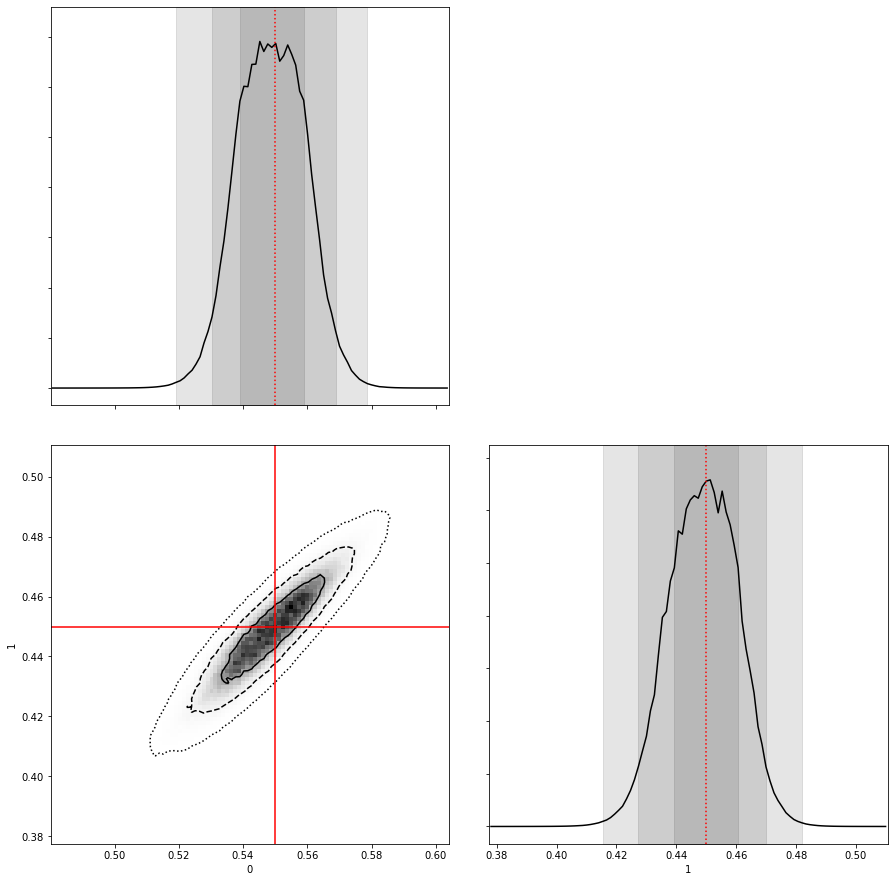

In [10]:
samples = task.sample(400000, obs0)
swyft.corner(samples, [0, 1], color='k', figsize = (15,15), truth=v0, bins = 100)